# 1. Reconstructing photoacoustic data

This example code shows how to load some example data and reconstruct it using backprojection. You can then apply spectral unmixing and visualise your data. 

First, we will import the required libraries. You can optionally set a default maximum batch size (-1 = run all data in one batch regardless of size) as shown below. 

In [1]:
# Set the maximum batch size (e.g. if you have memory limitations).
import os
os.environ["PAT_MAXIMUM_BATCH_SIZE"] = "-1"

import patato as pat
import matplotlib.pyplot as plt

We then load the example file. Alternatively, you can load in IPASC data format or others. Example data can be found in our example data repository [here](https://doi.org/10.17863/CAM.93181).

As an example dataset, we will use a dataset taken from a small-animal photoacoustic scanner (iThera inVision 256-TF, iThera Medical GmbH). We scanned a single slice through a tumour-bearing mouse.

In [2]:
padata = pat.PAData.from_hdf5("../intro/dataset/invivo_oe.hdf5")[0:1]

We then specify our preprocessor and reconstructor.

By default, the preprocessor will interpolate the time series data along the time and detector axes, apply a Hilbert transform and apply laser energy correction. Band-pass filters can also be applied (as shown here). 

Several implementations of different reconstruction algorithms are available in PATATO. Here we show the fastest and most simple, backprojection (delay and sum).

The variables `pre_processor` and `reconstructor` define instances that can be applied repeatedly to different datasets using the `.run` function (see below).

In [3]:
nx = 333 # number of pixels
lx = 2.5e-2 # m
pre_processor = pat.MSOTPreProcessor(lp_filter=7e6, hp_filter=5e3) # can specify low pass/high pass/hilbert etc.

reconstructor = pat.Backprojection(field_of_view=(lx, lx, 0), 
                                   n_pixels=(nx, nx, 1)) # z axis must be specified but is empty in this case.

Similarly, we can define a `SpectralUnmixer`. This applies linear spectral unmixing, converting our multi-wavelength data into approximations of deoxyhaemoglobin and haemoglobin content. It can equally be applied to other chromophores included in PATATO.

In [4]:
unmixer = pat.SpectralUnmixer(chromophores=["Hb", "HbO2"], 
                              wavelengths = padata.get_wavelengths(), rescaling_factor=4)
so2_calculator = pat.SO2Calculator(nan_invalid=True)

We can run each of these processing steps in turn using the `.run` function. 

The result of each step is a 3-element tuple. The first element is the primary result (e.g. reconstructed image, unmixed image etc.). The second element is a dictionary of settings that must be passed to the subsequent step in the processing pipeline. The third element is a list of any secondary results (e.g. baseline $sO_2$ in time-series analyses.

The processing steps used here (`pre_processor`, `reconstructor`, `unmixer`, `so2_calculator`) do not have any secondary results, so the third element is ignored with an underscore (`_`). 

In [5]:
# Apply the pre processor
filtered_time_series, settings, _ = pre_processor.run(padata.get_time_series(), padata)

# `settings` is a dictionary that includes the interpolated detection geometry. 
# It is passed into the next step

# Reconstruct the filtered time-series data. 
reconstruction, _, _ = reconstructor.run(filtered_time_series, padata, 
                                         padata.get_speed_of_sound(), **settings)

# Apply spectral unmixing and calculate the sO2 from the unmixing components.
unmixed, _, _ = unmixer.run(reconstruction, None)
so2, _, _ = so2_calculator.run(unmixed, None)

Visualisation in PATATO is made easy by taking your variable (reconstruction, unmixed image etc.) and applying the `.imshow` function. It is also possible to overlay regions of interest on top.

In the example dataset, polygon regions of interest were drawn previously around each tumour and a reference region (the spine). 

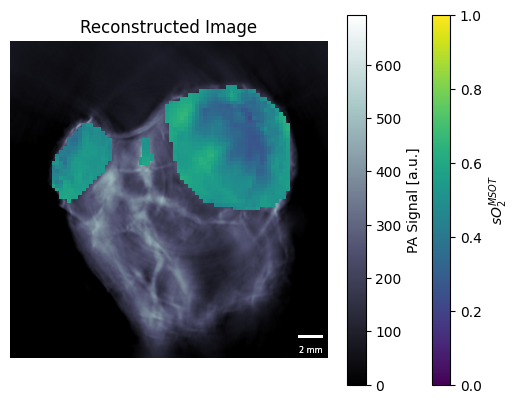

In [6]:
# Overlay the sO2 on top of the reconstructed image:
masks = [padata.get_rois()["tumour_right", "0"], 
         padata.get_rois()["tumour_left", "0"], 
         padata.get_rois()["reference_", "0"]]

# Show the image reconstruction in the background.
im1 = reconstruction.imshow(clim=(0, None))

# Overlay the sO2 image.
im = so2.imshow(clim=(0, 1), roi_mask=masks, cmap="viridis")

# Add titles, labels and a colorbar
plt.title("Reconstructed Image")
plt.colorbar(im, label="$sO_2^{MSOT}$")
plt.colorbar(im1, label="PA Signal [a.u.]")
plt.show()